# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler. 

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical. 
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. Challenges might be sampling convergence due to high energy barriers or entropy differences. 


To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states.




Here we calculate the Free Energy as:

$F_i = V_i - T_i  S_i = -\beta ln(Z_i) $



Or we can use the statistical approach:

$F_i(t) = -\frac{1}{\beta}  ln(\langle e^{-\beta H_i(t)}\rangle_i)$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta F_{ij} = F_j - F_i = -\beta ln(\frac{Z_i}{Z_j})$ 

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * TI
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


References:
    - a good page to learn about free energies: http://www.alchemistry.org 

In [1]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.samplers.stochastic import metropolisMonteCarloIntegrator, langevinIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import static_sim_plots

from ensembler.conditions.box_conditions import periodicBoundaryCondition

import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [2]:
simulation_steps_total_per_approach = 10000
space_range = [-10, 10]
rand=0.1


## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations. For this Notebook, we want to keep it simple. Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us. These two harmonic oscillators could for example describe the difference of types of bonds.


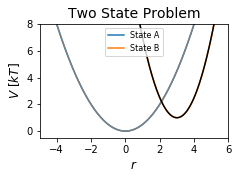

In [3]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 = 1

entropic_difference = k2 = 3 #2 #0.5
potential_difference = yoff2 = 1
phase_space_distance = xoff2 = 3

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([h1,h2])
positions = np.linspace(-10,10,1000)
enes1 = h1.ene(positions)
enes2 = h2.ene(positions)
ax = fig.gca()
ax.plot(positions, enes1, label="state A", c="grey")
ax.plot(positions, enes2, label="state A", c="k")

ax.set_ylim([-0.5,8])
ax.set_xlim([-5,6])
ax.set_title("Two State Problem")
#fig.tight_layout()
fig.savefig("2state_systems.png")


## Analyctical Solution
The Analytical solution for our problem can be calculated as follows: 


Check Eq

Gibbs Energy:   
$ F_i = V_i - T_i  S_i $

For a harmonic Oscillator the entropy term can be formulated as:

$F_i = V_i - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_i \beta}})$



The final free energy difference is:

$\Delta F_{ij} = F_j - F_i$ 


In [4]:
#Analytical Solution
beta = 1 # beta is in kT

G_1 = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
G_2 = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dG_expected = G_2-G_1

print("expected dG: ", dG_expected)


expected dG:  1.2746530721670273


## Free Energy Pertubation Method with BAR/Zwanzig
In this Category of methods, each of the endstates will be simulated seperatley. Afterwards, the trajectories will be evaluated  with the opposite state and afterwards the free energy will be evaluated.

### Sampling
Now we build first the two systems and run the simulations.

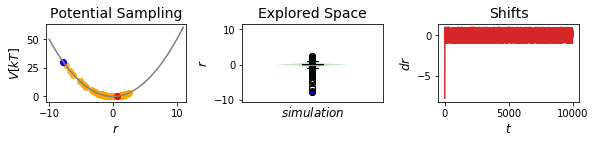

In [5]:
#Simulate the two states:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

##Build Systems
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
integrator2 = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

system1 = system(potential=h1, sampler=integrator)
system2 = system(potential=h2, sampler=integrator2)

##Simulate:
system1.simulate(steps)
state1_traj = system1.getTrajectory()
_ = static_sim_plots(system1, x_range=np.linspace(-10,10) )

### Analysis
#### Zwanzig Equation

In [6]:
V1=state1_traj.totEnergy[equilibration_steps:]
#V2=state2_traj.totEnergy[equilibration_steps:]
V2=h2.ene(state1_traj.position[equilibration_steps:])


zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dG_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dG_expected)


Expected Result:  1.2746530721670273
Zwanzig Result:  6.248058566928222

Difference: 4.973405494761195


#### Bennet Acceptance Ratio (BAR)

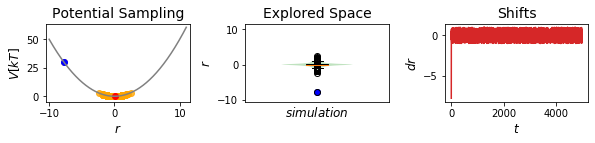

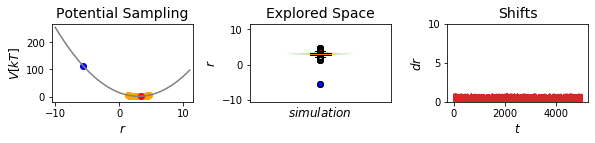

In [7]:
#Simulate the two states:
steps = simulation_steps_total_per_approach//2
equilibration_steps = 100

##Build Systems
sampler = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
sampler2 = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

system1 = system(potential=h1, sampler=sampler)
system2 = system(potential=h2, sampler=sampler2)

##Simulate:
system1.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system1.getTrajectory()
_ = static_sim_plots(system1, x_range=np.linspace(-10,10))

system2.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system2.getTrajectory()

#visualize
_ = static_sim_plots(system2, x_range=np.linspace(-10,10))
plt.ylim([0,10])
pass

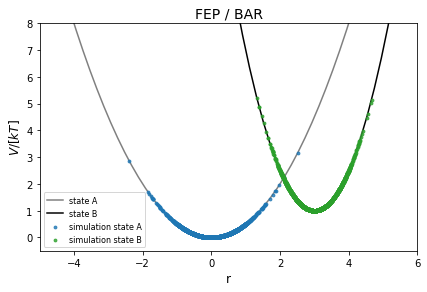

In [8]:
from ensembler import visualisation
    
positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(system1.trajectory.position)
ax[0].plot(positions, system1.potential.ene(positions), c="grey", label="state A", zorder=-10)
ene = system1.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="simulation state A",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(system2.trajectory.position)
ax[0].plot(positions, system2.potential.ene(positions), c="black", label="state B", zorder=-10)
ene = system2.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="simulation state B",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
ax[0].legend()
ax[0].set_title("FEP / BAR")
#ax[0].set_title("State 2")

fig.savefig("freeEnergyPertubation.png")

In [9]:
"""
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

w_fw = np.array(V21 - V11, dtype=np.float)
w_rv = np.array(V12 - V22, dtype=np.float)

(DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
(DeltaF, dDeltaF)


print()
print("Expected Result: ", dG_expected)
print("pymbar - BAR Result: ", DeltaF)
print()
print("Difference:", DeltaF - dG_expected)
"""

'\n#Sampling l1\nV11=h1.ene(state1_traj.position)\nV21=h2.ene(state1_traj.position)\n\n#Sampling l2\nV12=h1.ene(state2_traj.position)\nV22=h2.ene(state2_traj.position)\n\nw_fw = np.array(V21 - V11, dtype=np.float)\nw_rv = np.array(V12 - V22, dtype=np.float)\n\n(DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method=\'bisection\', verbose=False)\n(DeltaF, dDeltaF)\n\n\nprint()\nprint("Expected Result: ", dG_expected)\nprint("pymbar - BAR Result: ", DeltaF)\nprint()\nprint("Difference:", DeltaF - dG_expected)\n'

In [10]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("Expected Result: ", dG_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dG_expected)


Iterate: 	convergence raidus: 1e-05
Iteration: 0	dF: 2.729840265728076682961094204 	convergence 2.729840265728076682961094204
Iteration: 1	dF: 2.160313036737918720843064576 	convergence 0.569527228990157962118029628
Iteration: 2	dF: 2.258609453351535718226271084 	convergence 0.098296416613616997383206508
Iteration: 3	dF: 2.241303677448563169696205107 	convergence 0.017305775902972548530065977
Iteration: 4	dF: 2.244337324424387370047456818 	convergence 0.003033646975824200351251711
Iteration: 5	dF: 2.243805145025219021086699558 	convergence 0.000532179399168348960757260
Iteration: 6	dF: 2.243898490825208286336795684 	convergence 0.000093345799989265250096126
Iteration: 7	dF: 2.243882117331037362073328528 	convergence 0.000016373494170924263467156
Iteration: 8	dF: 2.243884989342880501313622396 	convergence 0.000002872011843139240293868

Final Iterations:  8  Result:  2.243884989342880501313622396

Expected Result:  1.2746530721670273
BAR Result:  2.2438849893428805

Difference: 0.9692319

# Linear Coupling Method - Thermodynamic Integration (TI)

## Sampling

Text(0.5, 1.0, 'Sampled Potentials')

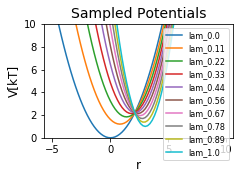

In [11]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lam(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [12]:
steps = simulation_steps_total_per_approach//lambda_points
equilibration_steps = 30

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
perturbed_system = perturbedSystem(potential=V_perturbed, sampler=integrator)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.set_lam(lam)
    perturbed_system.simulate(steps, withdrawTraj=True, initSystem=True)
    system_trajs.update({lam: perturbed_system.trajectory})


### Analysis

#### Exponential Formula

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


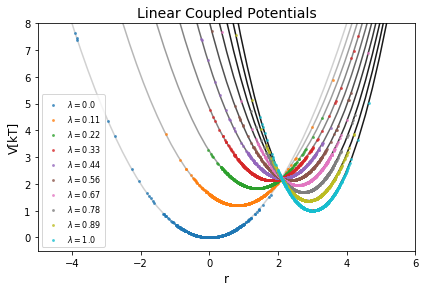

In [13]:
from ensembler import visualisation
from matplotlib import cm
#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [-0.5, 8]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))

for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lam(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    print(lamI)
    if(lamI==1): 
        c="black"
    else:
        c = cm.get_cmap("binary")(lamI+0.2)
    
    axes[0].plot(positions,ene, c=c, zorder=-10,alpha=0.9)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0, 
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")
    
logExp=list(map(lambda x: np.log(np.exp(x)), enes))

axes[0].legend()
axes[0].set_ylim(y_range)

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Linear Coupled Potentials")

axes[0].set_xlim([-5,6])


fig.savefig("linear_coupled.png")

### FEP with multiple lambda windows:

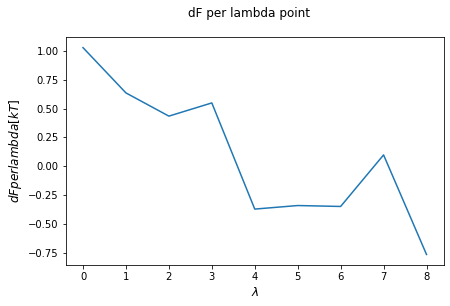


Expected Result:  1.2746530721670273
Sum of intermediates Result:  0.9211457194916198

Difference: -0.35350735267540745


In [14]:
dA_i_fw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.totPotEnergy
    Vj_fw = trajJ.totPotEnergy

    
    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)
    
    dA_i_fw.append(dF_zwanzig_fw)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(dA_i_fw)
axes.set_ylabel("$dFper lambda [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF per lambda point")

plt.show()

dF_FEP_10lambda = np.sum(dA_i_fw)

print()
print("Expected Result: ", dG_expected)
print("Sum of intermediates Result: ", dF_FEP_10lambda)
print()
print("Difference:", dF_FEP_10lambda - dG_expected)


#### Thermodynamic Integration

Text(0.5, 0.98, 'dH/d$\\lambda$ for each Lambda point')

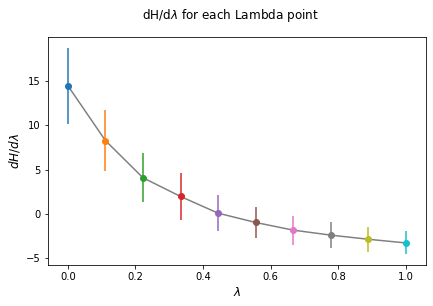

In [15]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dH/d$\lambda$ for each Lambda point")


In [16]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 


In [17]:
dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  1.2746530721670273
trapez Rule Result:  1.3105817377444142 +- 2.217791213397503

Difference: 0.03592866557738694


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

Text(0.5, 1.0, 'Sampled Potentials')

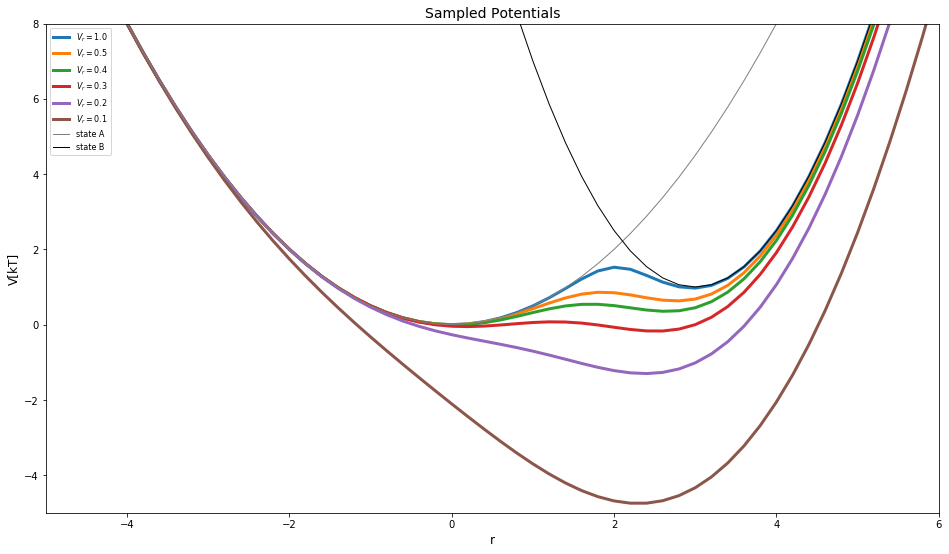

In [18]:
#Build Potential
s=1
Eoff = [0, 0]
V_eds = pot.envelopedPotential(V_is=[h1,h2] , s=s, Eoff_i=Eoff)
s_values = np.array([ 1,0.5, 0.4, 0.3, 0.2, 0.1])

#Visualize
positions = np.arange(-10,15, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_eds.s=s
    plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state B", lw=1, color="black")

V_eds.s=0.3
plt.legend()  
plt.ylim([-5,8])
plt.xlim([-5,6])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [19]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

good_s_value=0.3
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
eds_system = edsSystem(potential=V_eds, sampler=integrator, eds_s=good_s_value, eds_Eoff=Eoff)

eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
eds_traj = eds_system.getTrajectory()

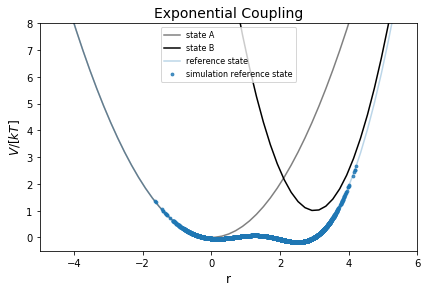

In [20]:
from ensembler import visualisation
    
traj = eds_traj.iloc[equilibration_steps:]
positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)
V_eds.s = traj.s[equilibration_steps]
eds_ene = V_eds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.totPotEnergy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, h1_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, h2_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C0", label="reference state", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C0",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("Exponential Coupling")

fig.savefig("EDS_sampling.png")

### FEP-EDS_Evaluation

In [23]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)


traj_positions = eds_traj.position[equilibration_steps:]
Vr = eds_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(traj_positions)
V2 = h2.ene(traj_positions)

dF_EDS = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)

print("dF ", dF_EDS)
print("deviation: ", dF_EDS-dG_expected)




dF  20.53856878704011
deviation:  19.263915714873082


### BAR-EDS_Evaluation

In [ ]:
"""

traj_positions = eds_traj.position[equilibration_steps:]
Vr = eds_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(traj_positions)
V2 = h2.ene(traj_positions)

w_fw = np.array(V1 - Vr, dtype=np.float)
w_rv = np.array(V2 - Vr, dtype=np.float)
(DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
print("dF_BAR:  ", DeltaF)
print("deviation: ", DeltaF-dG_expected)

"""


In [ ]:

traj_positions = eds_traj.position[equilibration_steps:]
Vr = eds_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(traj_positions)
V2 = h2.ene(traj_positions)

bar = bennetAcceptanceRatio(kT=True)
dF_EDSbar = bar.calculate(Vj_i=V1, Vi_i=Vr, Vi_j=V2, Vj_j=Vr)
print("dF_BAR:  ", dF_EDSbar)
print("deviation: ", dF_EDSbar-dG_expected)





# Hybrid Methods - $\lambda-EDS $

0 	 100.0
1 	 1.0
2 	 0.5
3 	 0.3
4 	 0.2
5 	 0.1


Text(0.5, 1.0, 'Sampled Potentials')

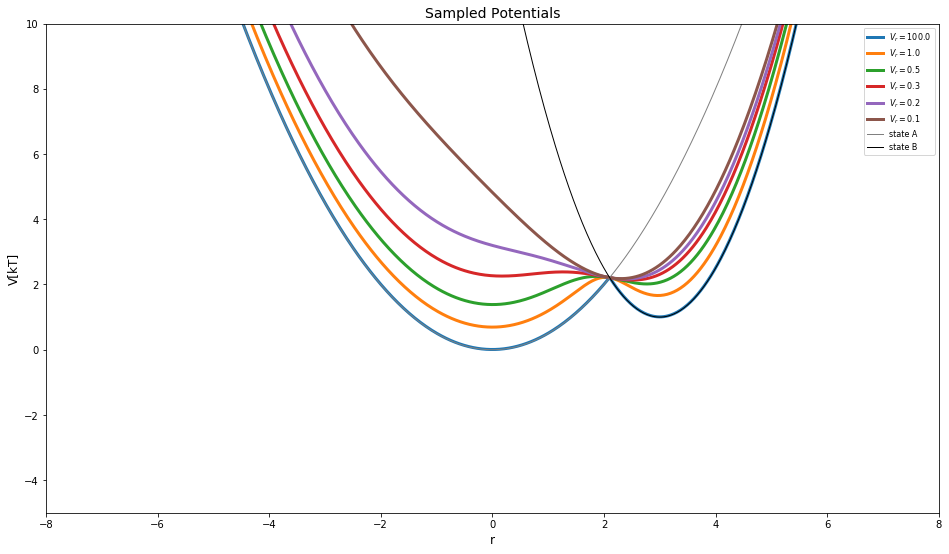

In [9]:
#Build Potential
s=1
Eoff = [0,0]
V_hleds = pot.lambdaEDSPotential(V_is=[h1,h2] , s=s, lam=0.5)
s_values = np.array([100, 1, 0.5, 0.3, 0.2, 0.1])

#Visualize
positions = np.linspace(-10,10, 1000)
fig = plt.figure(figsize=[16,9])

for ind,s in enumerate(s_values):
    print(ind, "\t", s)
    V_hleds.s=s
    plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state B", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


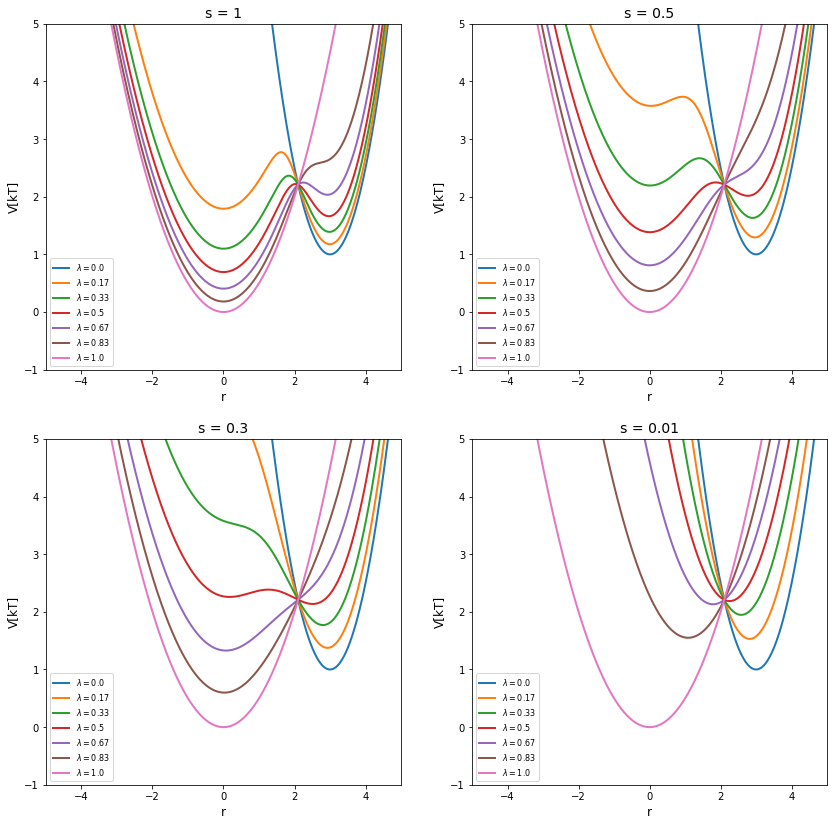

In [6]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[14,14])
axes = np.concatenate(axes)
s_values = [1, 0.5,  0.3, 0.01]
lams=list(sorted(list(np.linspace(start=0, stop=1, num=7))))


for ax, s in zip(axes, s_values):
    V_hleds.s= s
    for ind,lam in enumerate(lams):
        V_hleds.lam=lam
        ax.plot(positions,V_hleds.ene(positions), lw=2, label="$\lambda="+str(round(lam,2))+"$")

    #ax.plot(positions,h1.ene(positions), label="state A", lw=1, color="grey", zorder=10)
    #ax.plot(positions,h2.ene(positions), label="state B", lw=1, color="black", zorder=10)

    ax.legend()  
    ax.set_ylim([-1,5])
    ax.set_xlim([-5,5])

    ax.set_ylabel("V[kT]")
    ax.set_xlabel("r")
    ax.set_title("s = "+str(s))

In [19]:
#simulate
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
hleds_system = edsSystem(potential=V_hleds, sampler=integrator, eds_Eoff=Eoff)

hleds_simulation_trajs = []
good_s_value = 0.3
hleds_system.set_s(good_s_value)
hleds_system.potential.lam = 0.5
hleds_system.simulate(steps, withdrawTraj=True, initSystem=True)
hleds_simulation_traj = hleds_system.getTrajectory()

hleds_system.potential.lam = 0.25
hleds_system.simulate(steps, withdrawTraj=True, initSystem=True)
hleds_simulation_traj2 = hleds_system.getTrajectory()


hleds_system.potential.lam = 0.75
hleds_system.simulate(steps, withdrawTraj=True, initSystem=True)
hleds_simulation_traj3 = hleds_system.getTrajectory()

In [20]:
hleds_simulation_traj3.columns

Index(['position', 'temperature', 'totEnergy', 'totPotEnergy', 'totKinEnergy',
       'dhdpos', 'velocity', 's', 'Eoff'],
      dtype='object')

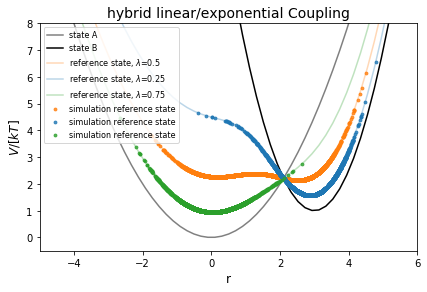

In [22]:
from ensembler import visualisation
    
traj = hleds_simulation_traj.iloc[equilibration_steps:]
traj2 = hleds_simulation_traj2.iloc[equilibration_steps:]
traj3 = hleds_simulation_traj3.iloc[equilibration_steps:]

positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)
V_hleds.s = traj.s[equilibration_steps]

V_hleds.lam = 0.5
eds_ene = V_hleds.ene(positions)
V_hleds.lam = 0.25
eds_ene1 = V_hleds.ene(positions)
V_hleds.lam = 0.75
eds_ene2 = V_hleds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.totPotEnergy)
traj_pos2 = list(traj2.position)
traj_ene2 = list(traj2.totPotEnergy)
traj_pos3 = list(traj3.position)
traj_ene3 = list(traj3.totPotEnergy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, h1_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, h2_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C1", label="reference state, $\lambda$=0.5", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene1, c="C0", label="reference state, $\lambda$=0.25", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene2, c="C2", label="reference state, $\lambda$=0.75", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C1",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos2, traj_ene2, c="C0",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos3, traj_ene3, c="C2",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
    
ax[0].legend()
ax[0].set_title("hybrid linear/exponential Coupling")

fig.savefig("hlEDS_sampling.png")

In [29]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)
zwanz = zwanzigEquation(kT=True)

traj_positions = hleds_simulation_traj.position[equilibration_steps:]
Vr = hleds_simulation_traj.totPotEnergy[equilibration_steps:]
V1 = h1.ene(traj_positions)
V2 = h2.ene(traj_positions)

dF_leds = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)

print("dF ", dF_leds)
print("deviation: ", dF_leds-dG_expected)
    


dF  18.2623456431323
deviation:  16.987692570965272


#### Enhanced Sampling with system Coupling

#### Conveyor Belt TI

In [ ]:
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.system import perturbed_system

#CHEKC HERE H1 and H2 die
equilibration_steps = 100
numsys = 4
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

lam_system = perturbed_system.perturbedSystem(potential=V_perturbed , integrator=integrator)
conveyorBelt=cvb.ConveyorBelt(0.0, numsys, system=lam_system, build=False)


In [ ]:
conveyorBelt.simulate(simulation_steps_total_per_approach//numsys)
cvb_trajs = conveyorBelt.get_trajectories()


In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=style.figsize_doubleColumn, sharex=True)
keys=list(sorted(list(cvb_trajs.keys())))
for key in keys:
    axes[key].plot(cvb_trajs[key].lam)
    axes[key].set_ylabel("$\lambda_"+str(key+1)+"$")
    if(key == keys[-1]):    axes[key].set_xlabel("$time [steps]$")
fig.suptitle("Conveyor belt replica sampling", y=1.05)
fig.tight_layout()

<BarContainer object of 50 artists>

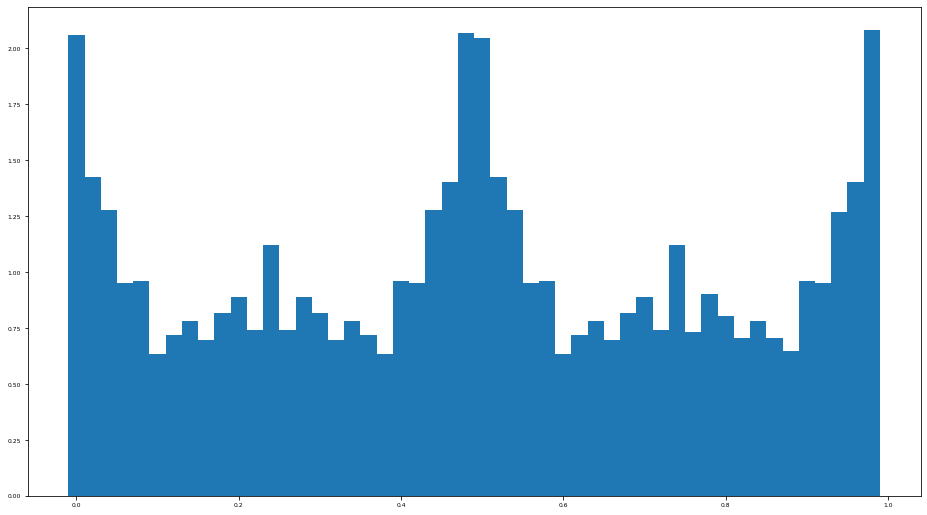

In [32]:
import pandas as pd
nbins=50
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

frequencies, lam_bins = np.histogram(list(sorted(np.unique(mega_traj.lam))), bins=nbins, density=True)
plt.figure(figsize=[16,9])
plt.bar(x=lam_bins[:-1], height=frequencies, width=1/nbins)

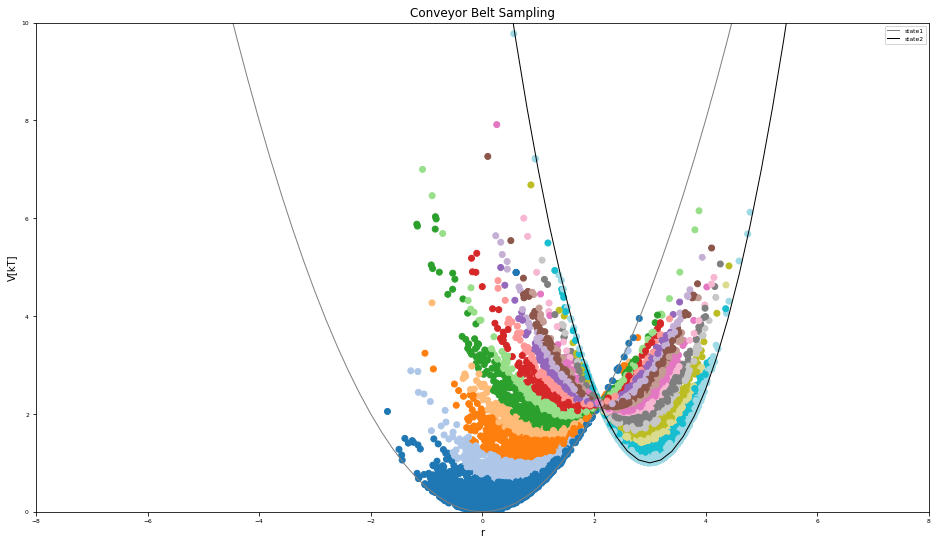

In [33]:
import pandas as pd
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

def find_nearest_bin(array,value):
    cbins =[]
    for val in value:
        idx = np.argmin(np.abs(array-val))
        cbins.append(idx)
    return cbins

discrete_traj = np.array(find_nearest_bin(value=mega_traj.lam[equilibration_steps:], array=lam_bins))

fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.totPotEnergy[equilibration_steps:], c=discrete_traj, cmap="tab20")

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)
positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, h1.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, h2.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")
fig.savefig("CVB_sampling.png")

In [34]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]

means_cvb = np.nan_to_num([np.mean(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)])
std_cvb = np.nan_to_num([np.std(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)] )


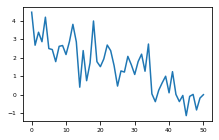

In [35]:
plt.plot(means_cvb)

In [36]:
dF_cvb_trapez = integrate.trapz(x=lam_bins, y=means_cvb)
dF_err = integrate.trapz(x=means_cvb, y=std_cvb)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_cvb_trapez, "+-", dF_err)
print()
print("Difference:", dF_cvb_trapez - dG_expected)





Expected Result:  1.27465307217
trapez Rule Result:  1.52263473619 +- -26.9385992479

Difference: 0.247981664025


# RE-EDS

[0, 0]
DO trials:  30 steps:  333
[1.0, 0.599484250318941, 0.35938136638046275, 0.2154434690031884, 0.1291549665014884, 0.0774263682681127, 0.046415888336127795, 0.02782559402207126, 0.016681005372000592, 0.01]
0 	 <ensembler.system.eds_system.edsSystem object at 0x000001C62D929AC8>
[1.0, 1.0]
[0, 0]
1 	 <ensembler.system.eds_system.edsSystem object at 0x000001C62CD41E08>
[0.599484250318941, 0.599484250318941]
[0, 0]
2 	 <ensembler.system.eds_system.edsSystem object at 0x000001C62A3E5FC8>
[0.35938136638046275, 0.35938136638046275]
[0, 0]
3 	 <ensembler.system.eds_system.edsSystem object at 0x000001C62D26A108>
[0.2154434690031884, 0.2154434690031884]
[0, 0]
4 	 <ensembler.system.eds_system.edsSystem object at 0x000001C62D069748>
[0.1291549665014884, 0.1291549665014884]
[0, 0]
5 	 <ensembler.system.eds_system.edsSystem object at 0x000001C62CD6B908>
[0.0774263682681127, 0.0774263682681127]
[0, 0]
6 	 <ensembler.system.eds_system.edsSystem object at 0x000001C62CA6FCC8>
[0.04641588833612779

Text(0.5, 1.0, 'Sampled Potentials')

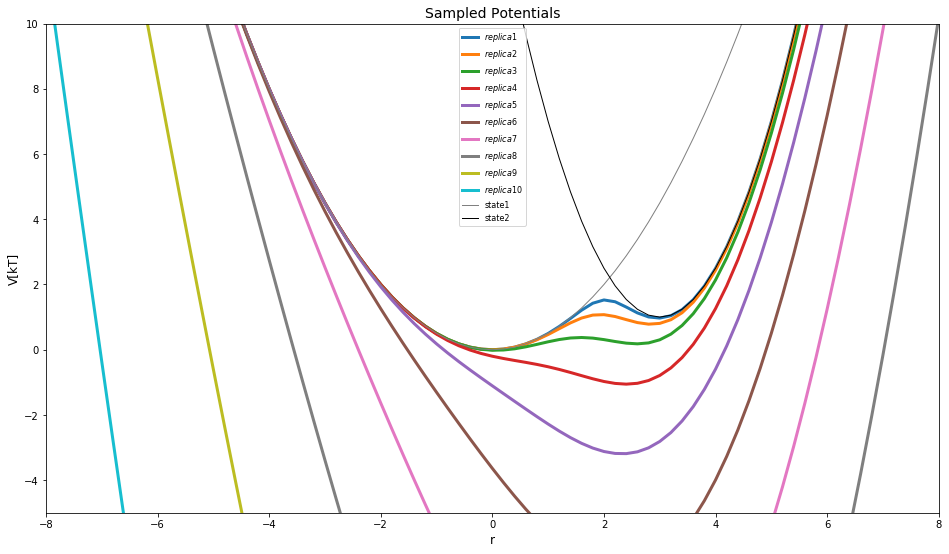

In [19]:
#potential
Eoff = [0,0]
V_eds = pot.envelopedPotential(V_is=[h1,h2])

##Integrator
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

##System
eds_system = edsSystem(sampler=integrator, potential=V_eds, start_position=4)
eds_system.Eoff = Eoff
print(eds_system.potential.Eoff)

##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-2, num=10)
trials=30
steps_between_trials=simulation_steps_total_per_approach//(trials) #len(s_values)*

print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.ReplicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None, s_range=s_values, steps_between_trials=steps_between_trials)
print([replica.s for repID, replica in ensemble.replicas.items()])

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,replica in ensemble.replicas.items():
    print(ind, "\t", replica)
    print(replica.potential.s)
    print(replica.potential.Eoff)

    plt.plot(positions,replica.potential.ene(positions), lw=3, label="$replica "+str(ind+1)+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


In [20]:
ensemble.simulate(trials, reset_ensemble=True)
reeds_trajs = ensemble.get_trajectories()


In [21]:
reeds_trajs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

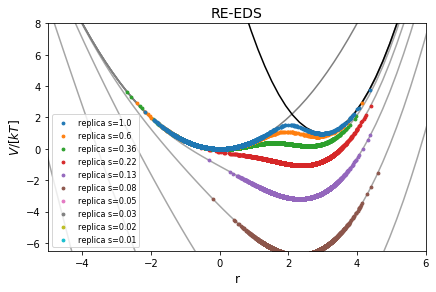

In [22]:

positions = np.linspace(-10,10)
fig, ax = plt.subplots(ncols=1, figsize=style.figsize_doubleColumn)
eqil=100
keys = sorted(list(reeds_trajs.keys()), reverse=False)
              
positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)

ax.plot(positions, h1_ene, c="grey", zorder=-10,)
ax.plot(positions, h2_ene, c="black", zorder=-10)

for traj in keys:
    s =  round(ensemble.replicas[traj].s,2)
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey", alpha=0.7, zorder=-60)
    min_e = np.min(reeds_trajs[traj].totEnergy[eqil:])
    ax.scatter(reeds_trajs[traj].position[eqil:], reeds_trajs[traj].totEnergy[eqil:], zorder=-traj, c="C"+str(traj),s=8, label="replica s="+str(s))

ax.set_ylim([-6.5,8])
ax.set_xlim([-5,6])
ax.set_xlabel("r")
ax.set_ylabel("$V/[kT]$")
ax.legend()
ax.set_title("RE-EDS")
fig.savefig("REEDS.png")

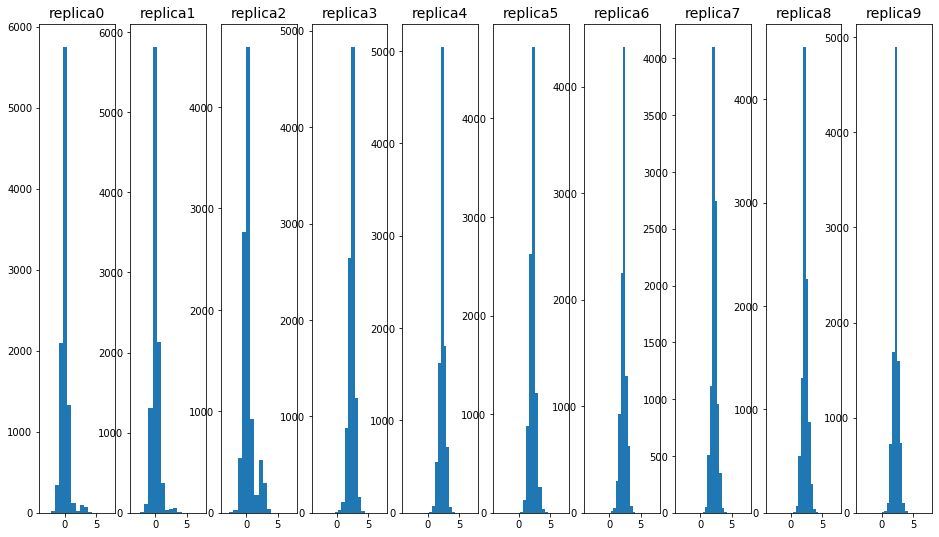

In [23]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.hist(reeds_trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


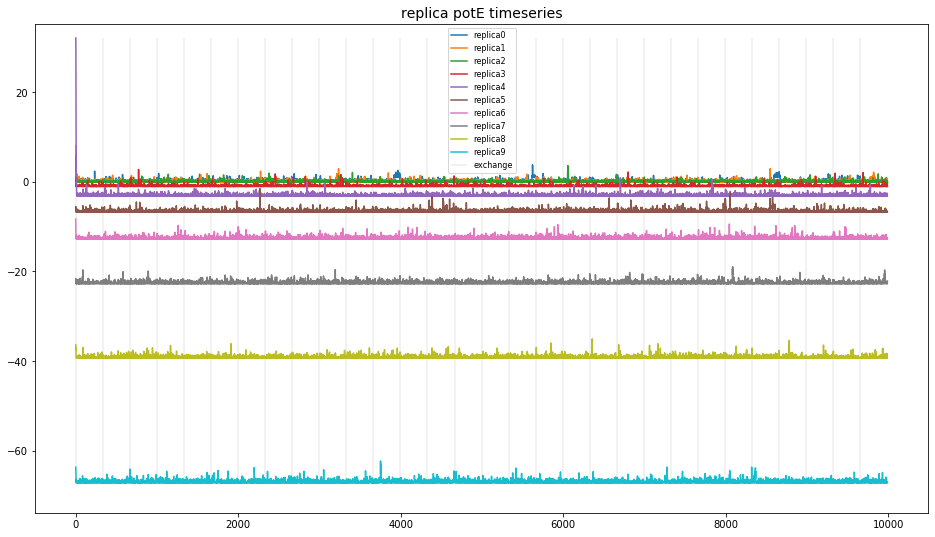

In [24]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [reeds_trajs[x].totEnergy for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

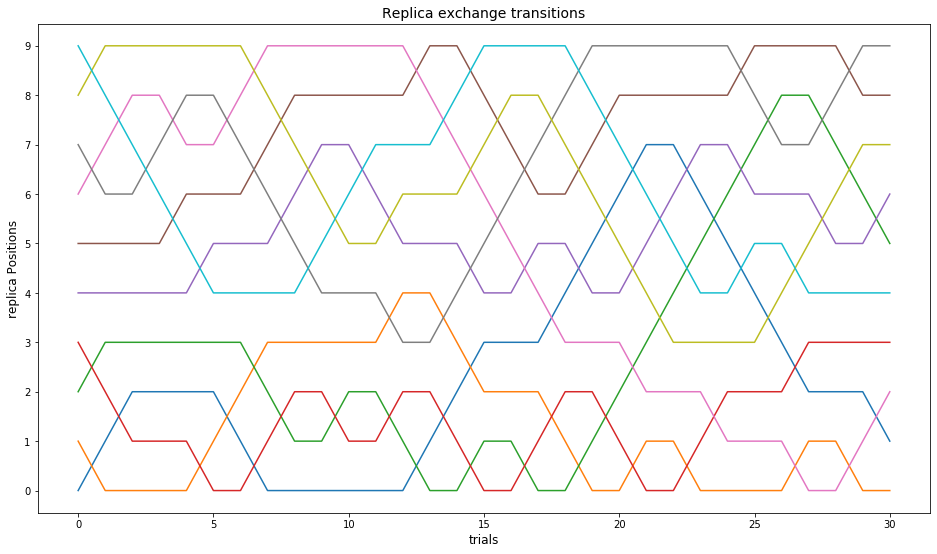

In [25]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [26]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)
zwanz = zwanzigEquation(kT=True)
equilibration_steps=10
#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    print(ind, key)
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].totPotEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    dFresults.append(dFRew_zwanz)
    
    df1 = zwanz.calculate(Vi=V1, Vj=V2)
    df1r = zwanz.calculate(Vi=V1, Vj=Vr)
    df2r = zwanz.calculate(Vi=Vr, Vj=V2)
    print("MAN ", df2r+df1r)
    print(df1, df1r, df2r)
    print(df1-dG_expected)
    print("Replica ", ind)
    print("s: ",reeds_trajs[key].s[1])
    print("dF_rew =  ", dFRew_zwanz)

print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")

0 0
MAN  3.24806777041827
-0.03651177097463787 -0.7115696954694002 3.95963746588767
-1.3111648431416651
Replica  0
s:  1.0
dF_rew =   29.034762115894353
1 1
MAN  4.233748105333518
0.8353084994685771 -0.4076901519464382 4.641438257279956
-0.4393445726984502
Replica  1
s:  0.599484250318941
dF_rew =   32.55850705754422
2 2
MAN  2.017046936612636
-0.44172461190137646 -1.4544736528682227 3.4715205894808587
-1.7163776840684037
Replica  2
s:  0.35938136638046275
dF_rew =   35.42816443318095
3 3
MAN  -1.7897112153623729
-2.3476967823970205 -4.326214672756145 2.5365034573937724
-3.622349854564048
Replica  3
s:  0.2154434690031884
dF_rew =   9.608793475440315
4 4
MAN  -1.5506448194259956
-2.171247233536589 -6.262282464601467 4.711637645175472
-3.445900305703616
Replica  4
s:  0.1291549665014884
dF_rew =   2.7997300679008585
5 5
MAN  -1.4699262029305782
-2.114631898885011 -9.757381289195298 8.28745508626472
-3.3892849710520383
Replica  5
s:  0.0774263682681127
dF_rew =   0.9276202370510163
6 6
M

In [28]:
reeds_trajs

{0:                   position  temperature  totEnergy  totPotEnergy  \
 0                 -1.45198        298.0   1.054124      1.054124   
 1      -0.7843972181257687        298.0   0.307639      0.307639   
 2     -0.47564023524568944        298.0   0.113117      0.113117   
 3     0.056630244491401194        298.0   0.001603      0.001603   
 4     -0.01603904089504904        298.0   0.000128      0.000128   
 ...                    ...          ...        ...           ...   
 9986   0.28824000334499644        298.0   0.041535      0.041535   
 9987  -0.02873069761937752        298.0   0.000412      0.000412   
 9988     0.780331291675722        298.0   0.304151      0.304151   
 9989   0.07854269710857131        298.0   0.003083      0.003083   
 9990  -0.05048160755810105        298.0   0.001274      0.001274   
 
       totKinEnergy                dhdpos  \
 0              NaN    1.4519807912539233   
 1              NaN    0.6675835731266148   
 2              NaN   0.30875698

In [44]:
keys = list(sorted(reeds_trajs.keys()))
pairwise = zip(keys,keys[1:])

dF_1_path = []
dF_2_path = []
for s1, s2 in pairwise:
    print(s1, s2)
    traj_s1 = reeds_trajs[s1]
    traj_s2 = reeds_trajs[s2]
    traj_s1_positions = traj_s1.position[equilibration_steps:]
    traj_s2_positions = traj_s2.position[equilibration_steps:]
    Vs1_1 = h1.ene(traj_s1_positions)
    Vs2_1 = h1.ene(traj_s2_positions)

    Vs1_2 = h2.ene(traj_s1_positions)
    Vs2_2 = h2.ene(traj_s2_positions)

    df1 = zwanz.calculate(Vi=Vs1_1, Vj=Vs2_1)
    df2 = zwanz.calculate(Vi=Vs1_2, Vj=Vs2_2)

    print(df1, df2)
    
    dF_1_path.append(df1)
    dF_2_path.append(df2)

ddF_1 = np.sum(dF_1_path)
ddF_2 = np.sum(dF_2_path)

0 1
-1.901863691247792 -21.590086570532513
1 2
-0.8703555014436386 -26.147491125377062
2 3
0.25148259978657794 -38.68319720319299
3 4
-1.5234513915501786 -10.169201550191858
4 5
-1.3203817211684967 -7.258537534536789
5 6
-1.4639908974991398 -4.508273061346957
6 7
-1.0988882822978887 -3.215556523767563
7 8
-1.0944535411104672 -2.0972729115737003
8 9
-1.2247130469264604 -2.265495974439565


In [43]:
ddF_1, ddF_2

(-10.246615473457485, -1.9984014443252814e-15)

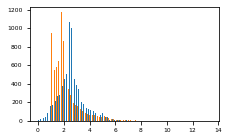

In [57]:
_ = plt.hist([V1, V2], bins=100)

(array([  1.50000000e+01,   5.30000000e+01,   4.61000000e+02,
          1.30100000e+03,   4.81100000e+03,   2.29400000e+03,
          8.81000000e+02,   1.45000000e+02,   1.70000000e+01,
          3.00000000e+00]),
 array([ 0.12813694,  0.57501892,  1.0219009 ,  1.46878288,  1.91566486,
         2.36254684,  2.80942883,  3.25631081,  3.70319279,  4.15007477,
         4.59695675]),
 <a list of 10 Patch objects>)

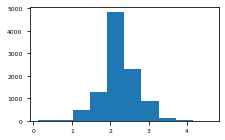

In [58]:
plt.hist(traj_positions)

#### 

In [59]:
"""
rew_zwanz = threeStateZwanzigReweighting(kT=True)
equilibration_steps=10
#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    w_fw = np.array(V1 - Vr, dtype=np.float)
    w_rv = np.array(V2 - Vr, dtype=np.float)

    (DeltaF, dDeltaF)=pymbar.BAR(w_F=w_rv, w_R=-w_fw, DeltaF=0, method='bisection', verbose=False)
    dFresults.append(DeltaF)

    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")
"""

'\nrew_zwanz = threeStateZwanzigReweighting(kT=True)\nequilibration_steps=10\n#State Potentials\nh1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) \nh2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)\n\ndFresults = []\ns_vals = []\nfor ind,key in enumerate(reeds_trajs):\n    s_vals.append(reeds_trajs[key].s[1])\n    traj_positions = reeds_trajs[key].position[equilibration_steps:]\n    Vr = reeds_trajs[key].totEnergy[equilibration_steps:]\n    V1 = h1.ene(traj_positions)\n    V2 = h2.ene(traj_positions)\n\n    w_fw = np.array(V1 - Vr, dtype=np.float)\n    w_rv = np.array(V2 - Vr, dtype=np.float)\n\n    (DeltaF, dDeltaF)=pymbar.BAR(w_F=w_rv, w_R=-w_fw, DeltaF=0, method=\'bisection\', verbose=False)\n    dFresults.append(DeltaF)\n\n    \nprint()\nprint("\tExpected Result: ", dG_expected)\nprint("s\t\tdF\t\tdiff")\nprint("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))\nprint(

# Final Results

In [48]:
print("analytical ",dG_expected)
print("FEP ", dF_zwanzig)
print("BAR ", dF_bar)
print("FEP 10-lambda",dF_FEP_10lambda)
print("TI", dF_trapez)
print("EDS", dF_EDS)
print("lEDS", dF_leds)
print("cvb", dF_cvb_trapez)
print("REEDS", dFresults)
print("EDS_BAR", dF_EDSbar)



analytical  1.27465307217
FEP  7.7494223182430915
BAR  2.146339823200502
FEP 10-lambda 1.44491660021
TI 1.25277833807
EDS 0.7477342331983707
lEDS 0.9417166780862306
cvb 1.52263473619
REEDS [4.276721077319407, 4.521525235448824, 2.7642559548332724, -0.5939665778705128, -0.4357866327918085, 1.2589381250670506, -0.16998894893600536, 0.027765290527888453, -0.17668556303567584, -0.1768135445501855]
EDS_BAR 1.8895732962560245
